# Imports

In [1]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================

# --- Manejo de Datos ---
import os
import pandas as pd
import numpy as np
import warnings

# --- Pipeline y Preprocesamiento ---
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import Pool
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# --- Modelado ---
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost.callback import EarlyStopping as XGBEarlyStopping

# --- Métricas y Validación ---
from sklearn import metrics

# --- Visualización (incluyendo las usadas en celdas comentadas) ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.inspection import permutation_importance


# Ignorar warnings para una presentación más limpia
warnings.filterwarnings("ignore")

from typing import List, Optional, Dict, Tuple

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:

# Leer parquet
df = pd.read_parquet("../data/df_merged.parquet")

# Revisar las primeras filas
print(df.head())


                       id              item    category    department  \
0  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
3  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
4  ACCESORIES_1_001_BOS_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   

       store store_code  region  yearweek  units_sold  sell_price    event  
0  South_End      BOS_1  Boston  201328.0           4     12.7414  Unknown  
1  South_End      BOS_1  Boston  201329.0           0     10.9858  Unknown  
2  South_End      BOS_1  Boston  201330.0           6     10.9858  Unknown  
3  South_End      BOS_1  Boston  201331.0           0     10.9858  Unknown  
4  South_End      BOS_1  Boston  201332.0           1     10.9858  Unknown  


In [4]:
# Paso 0: Calcular la columna de facturación (revenue)
df['revenue'] = df['units_sold'] * df['sell_price']
# Convertimos 'yearweek' (ej: 201328.0) a un formato de fecha para el eje X
# Cambiamos el día de la semana a Jueves ('4') según la nueva regla de negocio
df['date'] = pd.to_datetime(df['yearweek'].astype(int).astype(str) + '4', format='%Y%W%w')

In [5]:
for col in df.select_dtypes(include=['category']).columns:
    num_unique_values = df[col].nunique()
    print(f'Columna: {col}, Valores únicos: {num_unique_values}')

Columna: id, Valores únicos: 30490
Columna: item, Valores únicos: 3049
Columna: category, Valores únicos: 3
Columna: department, Valores únicos: 7
Columna: store, Valores únicos: 10
Columna: store_code, Valores únicos: 10
Columna: region, Valores únicos: 3
Columna: event, Valores únicos: 6


In [6]:
df

,id,item,category,department,store,store_code,region,yearweek,units_sold,sell_price,event,revenue,date
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201328.0,4,12.7414,Unknown,50.965599,2013-07-18
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201329.0,0,10.9858,Unknown,0.000000,2013-07-25
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201330.0,6,10.9858,Unknown,65.914795,2013-08-01
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201331.0,0,10.9858,Unknown,0.000000,2013-08-08
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201332.0,1,10.9858,Unknown,10.985800,2013-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6721781,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201613.0,22,1.2000,Easter,26.400002,2016-03-31
6721782,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201614.0,14,1.2000,Unknown,16.800001,2016-04-07
6721783,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201615.0,1,1.2000,Unknown,1.200000,2016-04-14
6721784,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,201616.0,0,1.2000,Unknown,0.000000,2016-04-21


In [7]:
# Ordenar por fecha antes del split temporal
df_sorted = df.sort_values("date")
target='units_sold'


In [8]:
df_sorted['date'].unique()

<DatetimeArray>
['2011-02-03 00:00:00', '2011-02-10 00:00:00', '2011-02-17 00:00:00',
 '2011-02-24 00:00:00', '2011-03-03 00:00:00', '2011-03-10 00:00:00',
 '2011-03-17 00:00:00', '2011-03-24 00:00:00', '2011-03-31 00:00:00',
 '2011-04-07 00:00:00',
 ...
 '2016-02-25 00:00:00', '2016-03-03 00:00:00', '2016-03-10 00:00:00',
 '2016-03-17 00:00:00', '2016-03-24 00:00:00', '2016-03-31 00:00:00',
 '2016-04-07 00:00:00', '2016-04-14 00:00:00', '2016-04-21 00:00:00',
 '2016-04-28 00:00:00']
Length: 274, dtype: datetime64[ns]

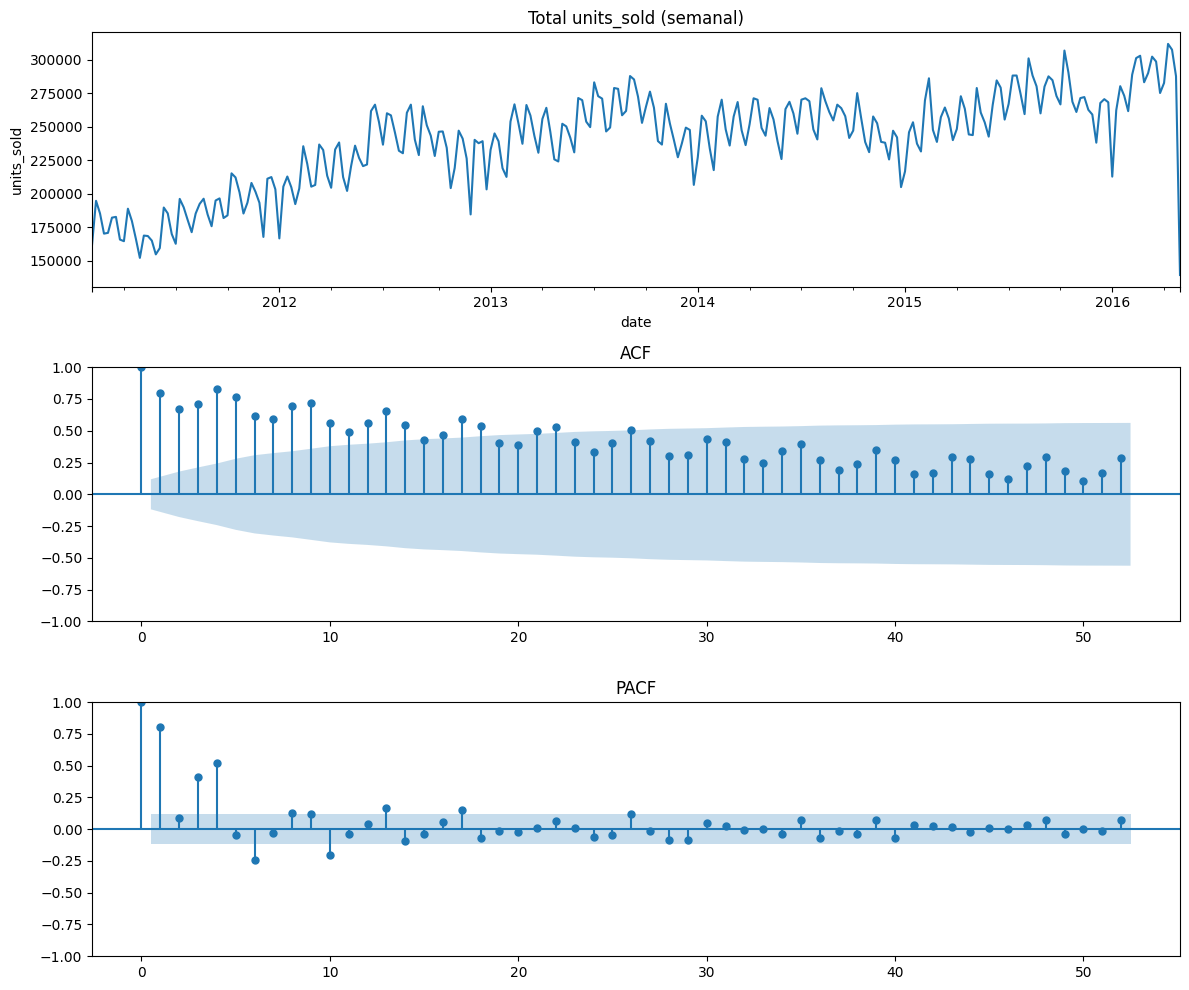

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ts_acf_pacf(y, title, max_lag=52):
    """
    y : pandas.Series con índice DateTime (frecuencia semanal)
    max_lag : nº máximo de lags (en semanas) a mostrar
    """
    fig = plt.figure(figsize=(12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1, sharex=False)

    # Serie
    y.plot(ax=ax1, title=title)
    ax1.set_ylabel("units_sold")

    # ACF y PACF
    plot_acf(y, ax=ax2, lags=max_lag)
    plot_pacf(y, ax=ax3, lags=max_lag, method='ywm')

    ax2.set_title("ACF")
    ax3.set_title("PACF")
    plt.tight_layout()
    plt.show()

# 1️⃣  Serie semanal agregada (todas las tiendas/items)
weekly_series = (
    df_sorted
    .set_index("date")
    .resample("W")["units_sold"]   # 'W' = semanal
    .sum()
)

# 2️⃣  Graficar hasta 52 semanas (un año de lags)
plot_ts_acf_pacf(weekly_series, "Total units_sold (semanal)", max_lag=52)


In [10]:
# ===============================
# Feature engineering (weekly data)
# ===============================
import numpy as np
import pandas as pd

# 0) Base ordenada
base = df_sorted.sort_values(['id','date']).copy()

# Tipos compactos
base['units_sold'] = base['units_sold'].astype('uint16')
base['sell_price'] = base['sell_price'].astype('float32')

# Claves temporales
base['year']  = base['date'].dt.year.astype('uint16')
base['month'] = base['date'].dt.month.astype('uint8')
base['week']  = base['date'].dt.isocalendar().week.astype('uint8')
base['dayofweek'] = base['date'].dt.dayofweek.astype('uint8')

# ---------- 1) LAGS por id ----------
for L in [1, 2, 3, 4]:
    base[f'units_lag_{L}'] = (
        base.groupby('id')['units_sold']
            .shift(L)
            .astype('float32')
    )

# ---------- 2) ROLLINGS por id (usar transform para alinear índices) ----------
for W in [4, 8, 12]:
    base[f'roll_mean_{W}'] = (
        base.groupby('id')['units_sold']
            .transform(lambda s: s.shift(1).rolling(W, min_periods=1).mean())
            .astype('float32')
    )
    base[f'roll_std_{W}'] = (
        base.groupby('id')['units_sold']
            .transform(lambda s: s.shift(1).rolling(W, min_periods=1).std())
            .astype('float32')
    )

# ---------- 3) Precio: nivel y cambio pasado por id ----------
base['price_lag_1']  = base.groupby('id')['sell_price'].shift(1).astype('float32')
base['price_diff_1'] = (base['sell_price'] - base['price_lag_1']).astype('float32')

# ---------- 4) Media semanal por store (lag 1 semana) ----------
weekly = (base.groupby(['store','year','week'], as_index=False)['units_sold']
            .mean()
            .rename(columns={'units_sold':'store_week_mean'}))
weekly = weekly.sort_values(['store','year','week'])
weekly['store_week_mean_lag1'] = weekly.groupby('store')['store_week_mean'].shift(1).astype('float32')

base = base.merge(
    weekly[['store','year','week','store_week_mean_lag1']],
    on=['store','year','week'],
    how='left'
)

# ---------- 5) Media semanal por categoría (lag 1) ----------
cat_week = (base.groupby(['category','year','week'], as_index=False)['units_sold']
              .mean()
              .rename(columns={'units_sold':'cat_week_mean'}))
cat_week = cat_week.sort_values(['category','year','week'])
cat_week['cat_week_mean_lag1'] = cat_week.groupby('category')['cat_week_mean'].shift(1).astype('float32')

base = base.merge(
    cat_week[['category','year','week','cat_week_mean_lag1']],
    on=['category','year','week'],
    how='left'
)

# ===============================
# Build df_model y split temporal
# ===============================
target   = 'units_sold'
cat_cols = ['category','department','store','region','event']
drop_cols = ['item','store_code','date','yearweek','revenue']  # 'id' lo puedes dejar o quitar

df_fe = base.drop(columns=drop_cols)

# Relleno de NaN de lags/rollings
lag_cols = [c for c in df_fe.columns if c.startswith(('units_lag_','roll_','price_')) or c.endswith('_lag1')]
df_fe[lag_cols] = df_fe[lag_cols].fillna(0.0).astype('float32')

# Split 80/20 por tiempo
split_idx = int(len(df_fe) * 0.8)
train_df = df_fe.iloc[:split_idx].copy()
val_df   = df_fe.iloc[split_idx:].copy()

X_train = train_df.drop(columns=[target])
y_train = train_df[target].astype('float32')
X_val   = val_df.drop(columns=[target])
y_val   = val_df[target].astype('float32')

# Para RF/XGB/LGBM -> OHE
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_val_enc   = pd.get_dummies(X_val,   columns=cat_cols, drop_first=True)
X_val_enc   = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)


In [ ]:
# Matriz de correlación
plt.figure(figsize=(16, 12))        
df_corr = train_df.corr(numeric_only=True)

sns.heatmap(
    df_corr,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f"                      # opcional: menos decimales
)
plt.title("Correlation matrix")
plt.tight_layout()   
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)              
plt.show()


CORRELACIONES MUY BAJAS!
EDIT: AL INCLUIR NUEVAS FEATURES, AUMENTA DRÁSTICAMENTE LA CORRELACIÓN CON LA TARGET DE NUESTRAS VARIABLES! 

In [12]:

# scaler=StandardScaler()
# X_train_scaled=scaler.fit_transform(X_train_enc)
# X_val_scaled=scaler.transform(X_val_enc)


De momento no aplicamos Scaler porque vamos a trabajar con arboles (RF, XGB, LGBM) NO con modelos lineales.

# Catboost

In [13]:
X_train.describe()

,sell_price,year,month,week,dayofweek,units_lag_1,units_lag_2,units_lag_3,units_lag_4,roll_mean_4,roll_std_4,roll_mean_8,roll_std_8,roll_mean_12,roll_std_12,price_lag_1,price_diff_1,store_week_mean_lag1,cat_week_mean_lag1
count,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5377428.0,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06,5.377428e+06
mean,6.049926e+00,2.013573e+03,6.354207e+00,2.597446e+01,3.0,7.542538e+00,7.508199e+00,7.471086e+00,7.433186e+00,7.535862e+00,3.106834e+00,7.536421e+00,3.509643e+00,7.538278e+00,3.751085e+00,6.022055e+00,4.961432e-04,9.673326e+00,8.515889e+00
std,4.640337e+00,1.472231e+00,3.527631e+00,1.545927e+01,0.0,1.975071e+01,1.972361e+01,1.969061e+01,1.965827e+01,1.868810e+01,6.701865e+00,1.824117e+01,7.335944e+00,1.797462e+01,7.741415e+00,4.646652e+00,2.073572e-01,3.662626e+00,4.746229e+00
min,1.200000e-02,2.011000e+03,1.000000e+00,1.000000e+00,3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.185750e+02,0.000000e+00,0.000000e+00
25%,2.976000e+00,2.012000e+03,3.000000e+00,1.200000e+01,3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.164966e-01,1.125000e+00,1.060660e+00,1.166667e+00,1.164500e+00,2.964000e+00,0.000000e+00,7.630849e+00,5.437003e+00
50%,4.912500e+00,2.014000e+03,6.000000e+00,2.600000e+01,3.0,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,1.707825e+00,3.125000e+00,1.995531e+00,3.166667e+00,2.110579e+00,4.881100e+00,0.000000e+00,9.047979e+00,6.504741e+00
75%,7.776000e+00,2.015000e+03,1.000000e+01,4.000000e+01,3.0,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,7.750000e+00,3.366502e+00,7.750000e+00,3.720119e+00,7.750000e+00,3.941812e+00,7.674100e+00,0.000000e+00,1.146300e+01,1.241693e+01
max,1.341500e+02,2.016000e+03,1.200000e+01,5.300000e+01,3.0,3.319000e+03,3.319000e+03,3.319000e+03,3.319000e+03,3.099250e+03,1.131189e+03,2.225000e+03,1.113425e+03,1.838917e+03,1.045388e+03,1.341500e+02,1.185750e+02,2.611120e+01,2.491986e+01


In [14]:
X_train.isna().sum()

id                      0
category                0
department              0
store                   0
region                  0
sell_price              0
event                   0
year                    0
month                   0
week                    0
dayofweek               0
units_lag_1             0
units_lag_2             0
units_lag_3             0
units_lag_4             0
roll_mean_4             0
roll_std_4              0
roll_mean_8             0
roll_std_8              0
roll_mean_12            0
roll_std_12             0
price_lag_1             0
price_diff_1            0
store_week_mean_lag1    0
cat_week_mean_lag1      0
dtype: int64

CatBoost / LightGBM / XGBoost: deja los NaNs. Estos modelos los manejan de forma nativa (envían los NaN por una rama “default”), y eso suele rendir mejor que inventarse valores.

In [ ]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn import metrics

# --- 0) ORDEN TEMPORAL GLOBAL antes del split ---
# (base = DataFrame tras crear TODAS las features)
base = base.sort_values('date').reset_index(drop=True)

# --- 1) Construir df para modelado (conservar 'date' hasta el split) ---
target = 'units_sold'
drop_later = ['item','store_code','yearweek','revenue']  # 'date' la quitamos después del split
df_fe = base.drop(columns=drop_later).copy()

# --- 2) Split 80/20 por tiempo ---
split_idx = int(len(df_fe) * 0.8)
train_df = df_fe.iloc[:split_idx].copy()
val_df   = df_fe.iloc[split_idx:].copy()

# ahora sí, ya podemos soltar 'date' para el modelo
for d in (train_df, val_df):
    d.drop(columns=['date'], inplace=True)

# --- 3) X, y (QUITAMOS 'id'; era solo para construir lags) ---
X_train = train_df.drop(columns=[target])
y_train = train_df[target].astype('float32')
X_val   = val_df.drop(columns=[target])
y_val   = val_df[target].astype('float32')

X_train_cb = X_train.drop(columns=['id']).copy()
X_val_cb   = X_val.drop(columns=['id']).copy()

# --- 4) Categóricas: detecta por dtype 'category' ---
cat_cols = [c for c in X_train_cb.columns if pd.api.types.is_categorical_dtype(X_train_cb[c])]
# Asegura mismo dtype en valid
for c in cat_cols:
    X_val_cb[c] = X_val_cb[c].astype(X_train_cb[c].dtype)
cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols]

# --- 5) Pools ---
train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx)
valid_pool = Pool(X_val_cb,   y_val,   cat_features=cat_idx)

# --- 6) CatBoost GPU (Bayesian bootstrap; early stopping) ---
model = CatBoostRegressor(
    task_type='GPU',
    devices='0',
    loss_function='Poisson',
    iterations=1200,
    learning_rate=0.08,
    depth=8,
    border_count=64,           # baja a 32 si falta VRAM
    one_hot_max_size=10,
    max_ctr_complexity=1,
    bootstrap_type='Bayesian', # usa bagging_temperature; no 'subsample'
    bagging_temperature=1.0,
    od_type='Iter', od_wait=200,
    use_best_model=True,
    random_seed=42,
    allow_writing_files=False
)

model.fit(train_pool, eval_set=valid_pool, verbose=200)

y_pred = model.predict(X_val_cb)
rmse = metrics.root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.4f}')
print('Categóricas usadas:', cat_cols)


0:	learn: 0.2300351	test: 0.4575076	best: 0.4575076 (0)	total: 121ms	remaining: 2m 24s
200:	learn: -23.1577386	test: -18.3612922	best: -18.3612922 (200)	total: 11s	remaining: 54.6s
400:	learn: -23.2249365	test: -18.3839811	best: -18.3839811 (400)	total: 21.8s	remaining: 43.4s
600:	learn: -23.2606101	test: -18.3926201	best: -18.3926841 (599)	total: 32.6s	remaining: 32.5s
800:	learn: -23.2860245	test: -18.3870621	best: -18.3953739 (745)	total: 43.4s	remaining: 21.6s
bestTest = -18.39537385
bestIteration = 745
Shrink model to first 746 iterations.
RMSE: 8.5801
Categóricas usadas: ['category', 'department', 'store', 'region', 'event']


# Scaled models (LGBM, XGB & RF)

## Random Forest

Random Forest no acepta NaNs asi que toca imputar

In [16]:
# columnas con NaN por construcción
nan_cols = [
    'units_lag_1','units_lag_2','units_lag_3','units_lag_4',
    'roll_mean_4','roll_std_4','roll_mean_8','roll_std_8',
    'roll_mean_12','roll_std_12',
    'price_lag_1','price_diff_1',
    'store_week_mean_lag1','cat_week_mean_lag1'
]

for d in (X_train, X_val):
    for c in nan_cols:
        if c in d.columns:
            d[c + '_miss'] = d[c].isna().astype('uint8')


In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_cat_cols = ['category','department','store','region','event']  # solo las de baja cardinalidad

# 1) Quita 'id' (y cualquier otra de alta cardinalidad) ANTES del OHE
X_train_rf = X_train.drop(columns=['id']).copy()
X_val_rf   = X_val.drop(columns=['id']).copy()

# 2) One-Hot Encoding SOLO a rf_cat_cols
X_train_rf = pd.get_dummies(X_train_rf, columns=rf_cat_cols, drop_first=True)
X_val_rf   = pd.get_dummies(X_val_rf,   columns=rf_cat_cols, drop_first=True)

# 3) Alinea columnas entre train y val
X_val_rf = X_val_rf.reindex(columns=X_train_rf.columns, fill_value=0)

# 4) Imputa NaNs de features derivadas (lags/rollings/etc.) para RF
na_cols = X_train_rf.columns[X_train_rf.isna().any()].tolist()
X_train_rf[na_cols] = X_train_rf[na_cols].fillna(0.0)
X_val_rf[na_cols]   = X_val_rf[na_cols].fillna(0.0)

# 5) Sanity checks: todo numérico, sin NaNs
assert X_train_rf.select_dtypes(include='object').empty, "Quedan columnas object en train"
assert X_val_rf.select_dtypes(include='object').empty,   "Quedan columnas object en val"
assert not X_train_rf.isna().any().any(), "Quedan NaNs en train"
assert not X_val_rf.isna().any().any(),   "Quedan NaNs en val"

# 6) Entrena RF
rf = RandomForestRegressor(
    n_estimators=100,      # ajusta si quieres más precisión
    max_depth=20,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    oob_score=False
)
rf.fit(X_train_rf, y_train)
y_pred = rf.predict(X_val_rf)

print("RMSE validación:", mean_squared_error(y_val, y_pred, squared=False))


RMSE validación: 8.066097363880136



## XGB


In [25]:
# df_fe = DF con features (sin 'date') que ya tienes
df_fe = df_fe.copy()
df_fe['date'] = pd.to_datetime(
    df_fe['year'].astype(int).astype(str)
  + df_fe['week'].astype(int).astype(str).str.zfill(2)
  + '4',                                  # 4 = jueves (Mon=0)
    format='%Y%W%w'
)

# Ahora igual que en la Opción A
df_fe = df_fe.sort_values('date').reset_index(drop=True)

split_idx  = int(len(df_fe) * 0.8)
split_date = df_fe.iloc[split_idx]['date']
train_df   = df_fe[df_fe['date'] <= split_date].copy()
val_df     = df_fe[df_fe['date']  > split_date].copy()

print("Train date max:", train_df['date'].max())
print("Val   date min:", val_df['date'].min())

for d in (train_df, val_df):
    d.drop(columns=['date'], inplace=True)

target = 'units_sold'
X_train = train_df.drop(columns=[target]);  y_train = train_df[target].astype('float32')
X_val   = val_df.drop(columns=[target]);    y_val   = val_df[target].astype('float32')

rf_cat_cols = ['category','department','store','region','event']
X_train_enc = pd.get_dummies(X_train.drop(columns=['id']), columns=rf_cat_cols, drop_first=True)
X_val_enc   = pd.get_dummies(X_val.drop(columns=['id']),   columns=rf_cat_cols, drop_first=True)
X_val_enc   = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)


Train date max: 2015-07-09 00:00:00
Val   date min: 2015-07-16 00:00:00


In [32]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- 0) Limpieza y tipos ---
# Si por error 'id' quedó en X_train_enc, lo quitamos
for df in (X_train_enc, X_val_enc):
    if 'id' in df.columns:
        df.drop(columns=['id'], inplace=True)

# XGBoost trabaja mejor y gasta menos memoria en float32
X_train_enc = X_train_enc.astype(np.float32)
X_val_enc   = X_val_enc.astype(np.float32)

# --- 1) Modelo XGB en GPU con early stopping ---
xgb = XGBRegressor(
    tree_method="gpu_hist",        # GPU
    predictor="gpu_predictor",     # (por compatibilidad)
    objective='count:poisson',
    n_estimators=5000,             # alto + early stopping
    learning_rate=0.05,
    max_depth=8,                   # 12 era pesado; 8 suele ir bien
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    max_bin=256,                   # menos VRAM que 512/1024
    random_state=42
)

xgb.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    eval_metric="rmse",
    verbose=200,
    early_stopping_rounds=200
)

# --- 2) Predicción y métrica ---
y_pred = xgb.predict(X_val_enc, iteration_range=(0, xgb.best_iteration + 1))
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE validación: {rmse:,.3f}")
print(f"Best iteration: {xgb.best_iteration}")


[0]	validation_0-rmse:79.65518
[200]	validation_0-rmse:8.64158
[400]	validation_0-rmse:8.51314
[600]	validation_0-rmse:8.44580
[800]	validation_0-rmse:8.44864
[940]	validation_0-rmse:8.45662
RMSE validación: 8.438
Best iteration: 741


## LGBM 

In [33]:
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error

lgbm = LGBMRegressor(
    device_type='gpu',      # usa GPU
    boosting_type='gbdt',
    objective='poisson',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
)

y_pred = lgbm.predict(X_val_enc)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 5382211, number of used features: 43
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (123.19 MB) transferred to GPU in 0.087682 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.303301


In [34]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE validación: {rmse:,.3f}")


RMSE validación: 7.972


In [31]:
!jupyter nbconvert --to markdown "Time_Series_model.ipynb"


[NbConvertApp] Converting notebook Time_Series_model.ipynb to markdown
[NbConvertApp] Support files will be in Time_Series_model_files\
[NbConvertApp] Writing 30921 bytes to Time_Series_model.md


Teniendo en cuenta la presencia mayoritaria de ceros en la target, podria ser una buena idea:
- Primero entrenar un algoritmo de clasificación para predecir: ventas =0 / !=0.
- Segundo entrenar un algoritmo de regresión para predecir el valor de las ventas != 0.
